## Layerwise Relevance Propagation
### CHAPTER 02 - *Model Explainability Methods*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

In this notebook, we will try to implement some of the concepts related to Layerwise Relevance Propagation part of the Influence based explainability methods discussed in Chapter 2 - Model Explainability Methods.

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade numpy matplotlib tensorflow

### Loading the modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Gradient Class Activation Map (Grad-CAM)

The popular technique of Grad-CAM is used as a visualization technique to explain the working of complex Convolution Neural Networks on unstrutured data like images. We will use tensorflow and keras framework to get a pretrained network on ImageNet dataset and test the approach on a sample open image obtained from the source: https://i.imgur.com/GleAY3f.jpeg. For more examples using Keras and tensorflow please visit: https://keras.io/examples/

In [2]:
model_builder = Xception
preprocess_input = preprocess_input
decode_predictions = decode_predictions
IMG_SIZE = (299, 299)
last_conv_layer = "block14_sepconv2_act"

### Loading the data

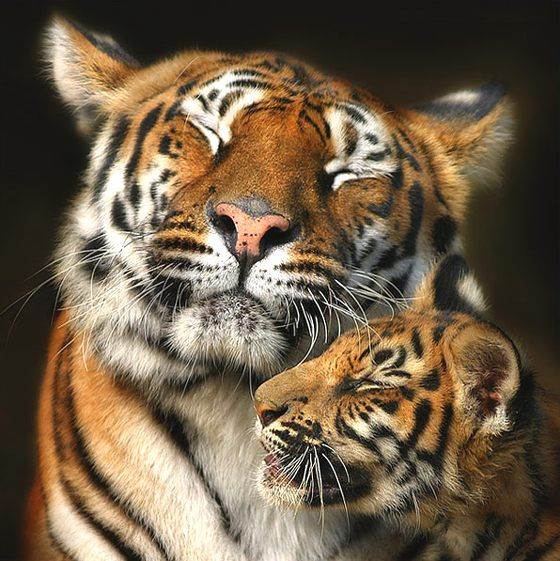

In [3]:
# The local path to our target image
image_path = keras.utils.get_file(
    "tiger.jpg", "https://i.imgur.com/GleAY3f.jpeg"
)

display(Image(image_path))

### Preprocessing

In [4]:
def vectorize_image(img_path, size):
    '''
    Vectorize the given image to get a numpy array
    '''
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    return array

In [5]:
vectorized_image = preprocess_input(vectorize_image(image_path, size=IMG_SIZE))
model = model_builder(weights="imagenet")
model.layers[-1].activation = None # Removing the last layer as it is the softmax layer used for classification

model_prediction = model.predict(vectorized_image)
print(f"The predicted class is : {decode_predictions(model_prediction, top=1)[0][0][1]}")

The predicted class is : tiger


### Building Grad-CAM Heat-map

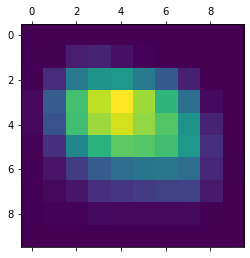

In [7]:
def get_heatmap(vectorized_image, model, last_conv_layer, pred_index=None):
    '''
    Function to visualize grad-cam heatmaps
    '''
    gradient_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    # Gradient Computations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = gradient_model(vectorized_image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # Normalize the heatmap
    return heatmap.numpy()

plt.matshow(get_heatmap(vectorized_image, model, last_conv_layer))
plt.show()

### Superimpose Grad-CAM Heatmap on image

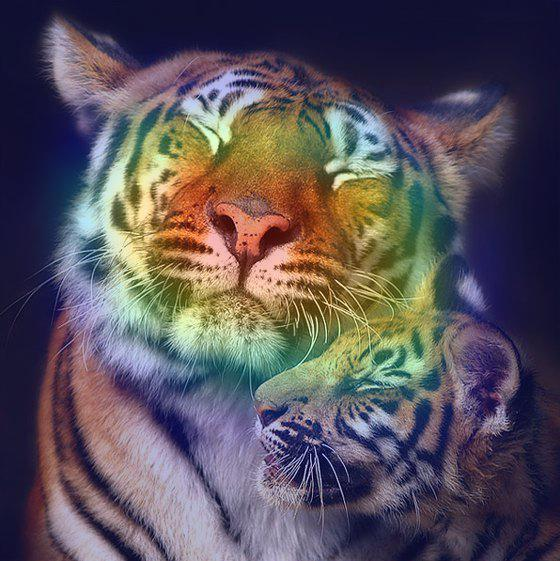

In [9]:
def superimpose_gradcam(img_path, heatmap, output_path="grad_cam_image.jpg", alpha=0.4):
    '''
    Superimpose Grad-CAM Heatmap on image
    '''
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap) # Back scaling to 0-255 from 0 - 1
    jet = c_map.get_cmap("jet") # Colorizing heatmap
    jet_colors = jet(np.arange(256))[:, :3] # Using RGB values
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    
    superimposed_img = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(output_path) # Saving the superimposed image
    display(Image(output_path)) # Displaying Grad-CAM Superimposed Image
    
superimpose_gradcam(image_path, get_heatmap(vectorized_image, model, last_conv_layer))

### Final Thoughts

This is a very powerful technique that is used to explain the working of complex Deep Learning algorithms on unstructured data like images. Although this method is difficult to unerstand for beginner learners, but once you get a hang of it, it is a very powerful method and very helpful for model explainability, 

### Reference

1. Keras Tensorflow Tutorial Examples - https://keras.io/examples/